In [2]:
import os
from pathlib import Path
import yfinance as yf
import json
import matplotlib.pyplot as plt
from typing import List

import pandas as pd
import numpy as np

In [3]:
tickers = {
    "tech": ["AAPL", "MSFT", "TSLA"],
    "healthcare": ["JNJ", "PFE", "MRK"],
    "financials": ["JPM", "BAC", "WFC"],
    "energy": ["XOM", "CVX", "SLB"],
    "consumer": ["PG", "KO", "WMT"],
    "commodities": ["GC=F", "CL=F"]
}

In [4]:
for sector, symbols in tickers.items():
    print(f"Fetching data for {sector} sector...")
    for symbol in symbols:
        try:
            ticker_data = yf.Ticker(symbol)
            hist = ticker_data.history(start="2010-01-01")
            hist.to_csv(f"historical_data/{symbol}_data.csv")
            print(f"{symbol} data fetched successfully.")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
    print(f"Finished fetching data for {sector} sector.\n")

Fetching data for tech sector...
AAPL data fetched successfully.
MSFT data fetched successfully.
TSLA data fetched successfully.
Finished fetching data for tech sector.

Fetching data for healthcare sector...
JNJ data fetched successfully.
PFE data fetched successfully.
MRK data fetched successfully.
Finished fetching data for healthcare sector.

Fetching data for financials sector...
JPM data fetched successfully.
BAC data fetched successfully.
WFC data fetched successfully.
Finished fetching data for financials sector.

Fetching data for energy sector...
XOM data fetched successfully.
CVX data fetched successfully.
SLB data fetched successfully.
Finished fetching data for energy sector.

Fetching data for consumer sector...
PG data fetched successfully.
KO data fetched successfully.
WMT data fetched successfully.
Finished fetching data for consumer sector.

Fetching data for commodities sector...
GC=F data fetched successfully.
CL=F data fetched successfully.
Finished fetching data f

In [ ]:
#!/usr/bin/env python3
"""
split_csv_by_date.py

For each CSV in `file_paths`, read it with pandas, split into train/test based on the 'Date' column,
and write out two new files:
    [original_filename]_train.csv   (all rows with Date < 2024-01-01)
    [original_filename]_test.csv    (all rows with Date >= 2024-01-01)

Usage:
    python split_csv_by_date.py

Adjust `file_paths` below (or modify this script to accept command-line arguments).
"""
# ----------------------------------------------------------------------
# STEP 1: Specify your CSV files here. You can list absolute or relative paths.
# ----------------------------------------------------------------------
file_paths = Path("historical_data").glob("*.csv")

# ----------------------------------------------------------------------
# STEP 2: Define the cutoff date for the test set
# ----------------------------------------------------------------------
# We want test = all rows with Date >= January 1, 2024
TEST_CUTOFF = pd.Timestamp("2024-01-01", tz="UTC")  # Ensure timezone consistency if needed

# ----------------------------------------------------------------------
# STEP 3: Loop over each CSV, read, split, and write out train/test
# ----------------------------------------------------------------------
for csv_path in file_paths:

    # 2. Read the CSV, parsing 'Date' as datetime:
    try:
        df = pd.read_csv(csv_path, parse_dates=["Date"])
    except Exception as e:
        print(f"Error reading '{csv_path}': {e}")
        continue

    # 3. Verify that the 'Date' column exists and is datetime64:
    if "Date" not in df.columns:
        print(f"Warning: 'Date' column not found in '{csv_path}'. Skipping.")
        continue

    if not pd.api.types.is_datetime64_any_dtype(df["Date"]):
        # If pandas did not parse it as datetime, try to convert explicitly:
        try:
            df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        except Exception as e:
            print(f"Could not convert 'Date' to datetime in '{csv_path}': {e}")
            continue

    # 4. Split into train/test
    mask_test = df["Date"] >= TEST_CUTOFF
    df_test = df.loc[mask_test].copy()
    df_train = df.loc[~mask_test].copy()

    # 5. Construct output filenames:
    base, ext = os.path.splitext(csv_path)
    train_path = f"{base}_train{ext}"
    test_path  = f"{base}_test{ext}"

    # 6. Write them out (index=False to avoid writing the index column unless you want it):
    try:
        df_train.to_csv(train_path, index=False)
        df_test.to_csv(test_path, index=False)
        print(f"Split '{csv_path}' →")
        print(f"    TRAIN ({len(df_train)} rows) → {train_path}")
        print(f"    TEST  ({len(df_test)} rows) → {test_path}")
    except Exception as e:
        print(f"Error writing split files for '{csv_path}': {e}")

In [ ]:
def moving_average_crossover(df: pd.DataFrame,
                             short_window: int = 20,
                             long_window: int = 50) -> pd.DataFrame:
    """
    Compute a simple moving‐average crossover strategy on `df`.
    Assumes `df` has a 'Date' column (or datetime index) and a 'Close' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Date' (or be indexed by datetime) and 'Close'.
    short_window : int
        Window size for the short SMA (e.g., 20 days).
    long_window : int
        Window size for the long SMA (e.g., 50 days).

    Returns
    -------
    pd.DataFrame
        Original DataFrame with the following added columns:
          - 'SMA_short' : short‐period moving average
          - 'SMA_long'  : long‐period moving average
          - 'Signal'    : 1 when short crosses above long,
                          -1 when short crosses below long, else 0
    """

    df = df.copy()

    # Ensure 'Date' is a datetime type and set as index if not already
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        df.set_index("Date", inplace=True)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or be indexed by datetime.")

    # 1) Compute Simple Moving Averages
    df["SMA_short"] = df["Close"].rolling(window=short_window, min_periods=1).mean()
    df["SMA_long"]  = df["Close"].rolling(window=long_window, min_periods=1).mean()

    # 2) Generate raw crossover signals: 
    #    - When SMA_short > SMA_long → 1 (long), when SMA_short < SMA_long → 0
    df["Crossover"] = np.where(df["SMA_short"] > df["SMA_long"], 1, 0)

    # 3) The actual “Signal” is the change in Crossover:
    #    - A rising edge (0→1) means a buy signal (1)
    #    - A falling edge (1→0) means a sell signal (−1)
    df["Signal"] = df["Crossover"].diff().fillna(0)
    df["Signal"] = df["Signal"].map({1.0: 1, -1.0: -1}).fillna(0).astype(int)

    # Rows where no crossover event happen remain at 0
    # Cleanup temporary column if you don’t need it:
    df.drop(columns=["Crossover"], inplace=True)

    return df

In [ ]:
def bollinger_bands_strategy(df: pd.DataFrame,
                             window: int = 20,
                             num_std: float = 2.0) -> pd.DataFrame:
    """
    Compute a simple Bollinger Bands breakout strategy on `df`.
    Assumes `df` has a 'Date' column (or datetime index) and a 'Close' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Date' (or be indexed by datetime) and 'Close'.
    window : int
        Rolling window size for moving average and standard deviation.
    num_std : float
        Number of standard deviations for upper/lower bands.

    Returns
    -------
    pd.DataFrame
        Original DataFrame with these added columns:
          - 'BB_mid'   : rolling mean (middle band)
          - 'BB_std'   : rolling standard deviation
          - 'BB_upper' : BB_mid + num_std * BB_std
          - 'BB_lower' : BB_mid − num_std * BB_std
          - 'Signal'   :  1 when Close < BB_lower (buy)
                          -1 when Close > BB_upper (sell), else 0
    """

    df = df.copy()

    # Ensure 'Date' is datetime and set as index if needed
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        df.set_index("Date", inplace=True)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or be indexed by datetime.")

    # 1) Compute rolling mean (mid) and rolling std (std) over 'window'
    df["BB_mid"] = df["Close"].rolling(window=window, min_periods=1).mean()
    df["BB_std"] = df["Close"].rolling(window=window, min_periods=1).std(ddof=0)

    # 2) Compute upper and lower bands
    df["BB_upper"] = df["BB_mid"] + (num_std * df["BB_std"])
    df["BB_lower"] = df["BB_mid"] - (num_std * df["BB_std"])

    # 3) Generate signals:
    #    - Buy (1)  when price closes below the lower band
    #    - Sell (-1) when price closes above the upper band
    conditions = [
        df["Close"] < df["BB_lower"],  # price has broken below lower band
        df["Close"] > df["BB_upper"],  # price has broken above upper band
    ]
    choices = [1, -1]

    df["Signal"] = np.select(conditions, choices, default=0).astype(int)

    return df

In [ ]:
def backtest_with_shorts(
    df: pd.DataFrame,
    price_col: str = "Close",
    signal_col: str = "Signal"
) -> List[float]:
    """
    Backtest a strategy that can go long (signal=+1), short (signal=-1), or flat (signal=0).
    For each change in signal, it closes any open position and (if new signal != 0) opens a new position.
    Returns a list of percent PnLs for each completed trade.

    Parameters
    ----------
    df : pd.DataFrame
        Must be sorted in ascending date order and contain:
          - price_col   : price at which to execute trades (float)
          - signal_col  : integer signal (+1=open long, -1=open short, 0=flat)
    price_col : str
        Name of the column with execution prices.
    signal_col : str
        Name of the column with signals (+1, -1, 0).

    Returns
    -------
    List[float]
        Percent PnLs for each round-trip (long or short) trade.
    """
    pnls: List[float] = []
    current_position = 0   # +1 for long, -1 for short, 0 for flat
    entry_price = None     # price at which the current position was opened

    for idx, row in df.iterrows():
        sig = int(row[signal_col])
        price = float(row[price_col])

        # If the signal changes from whatever we currently hold:
        if sig != current_position:
            # 1) Close any existing position
            if current_position != 0 and entry_price is not None:
                if current_position == 1:
                    # closing a long
                    pnl = (price - entry_price) / entry_price * 100.0
                else:  # current_position == -1, closing a short
                    pnl = (entry_price - price) / entry_price * 100.0

                pnls.append(pnl)
                entry_price = None
                current_position = 0

            # 2) Open a new position if sig != 0
            if sig != 0:
                current_position = sig
                entry_price = price

        # If sig == current_position, do nothing (hold the position)
        # If sig == 0 and current_position == 0, do nothing (remain flat)

    # At the end: if a position is still open, close it at the last price
    if current_position != 0 and entry_price is not None:
        last_price = float(df.iloc[-1][price_col])
        if current_position == 1:
            pnl = (last_price - entry_price) / entry_price * 100.0
        else:  # current_position == -1
            pnl = (entry_price - last_price) / entry_price * 100.0

        pnls.append(pnl)

    return pnls

In [ ]:
for sector, symbols in tickers.items():
    print(f"Processing strategies for {sector} sector...")
    for symbol in symbols:
        try:
            file_path = Path(f"historical_data/{symbol}_data.csv")
            if not file_path.exists():
                print(f"File {file_path} does not exist. Skipping.")
                continue

            df = pd.read_csv(file_path)

            # Apply moving average crossover strategy
            df_ma = moving_average_crossover(df)
            ma_pnls = backtest_with_shorts(df_ma)
            print(f"{symbol} MA Strategy PnLs: {ma_pnls}")

            with open(f"backtest_pnl/{symbol}_ma_strategy.json", "w") as f:
                json.dump(ma_pnls, f)

            # Apply Bollinger Bands strategy
            df_bb = bollinger_bands_strategy(df)
            bb_pnls = backtest_with_shorts(df_bb)
            print(f"{symbol} BB Strategy PnLs: {bb_pnls}")

            with open(f"backtest_pnl/{symbol}_bb_strategy.json", "w") as f:
                json.dump(bb_pnls, f)

        except Exception as e:
            print(f"Error processing {symbol}: {e}")
    print(f"Finished processing strategies for {sector} sector.\n")

In [ ]:
# # Cumulative PnL plot
# cumulative_pnl = np.cumsum(backtest_results)
# plt.figure(figsize=(12, 6))
# plt.plot(cumulative_pnl, marker='o', linestyle='-', color='blue')
# plt.title("Cumulative PnL from Backtest")
# plt.xlabel("Trade Number")
# plt.ylabel("Cumulative PnL (%)")
# plt.grid()
# plt.axhline(0, color='red', linestyle='--', linewidth=1)
# plt.show()

In [7]:
pnls_df = pd.DataFrame()
for sector, symbols in tickers.items():
    print(f"Processing strategies for {sector} sector...")
    for symbol in symbols:
        try:
            backtest_ema_path = Path(f"backtest_pnl/{symbol}_ma_strategy.json")
            if not backtest_ema_path.exists():
                print(f"File {backtest_ema_path} does not exist. Skipping.")
                continue
            with open(backtest_ema_path, "r") as f:
                ma_pnls = json.load(f)
            
            backtest_bb_path = Path(f"backtest_pnl/{symbol}_bb_strategy.json")
            if not backtest_bb_path.exists():
                print(f"File {backtest_bb_path} does not exist. Skipping.")
                continue
            with open(backtest_bb_path, "r") as f:
                bb_pnls = json.load(f)
            
            # Handle different lengths by padding with NaN
            max_len = max(len(ma_pnls), len(bb_pnls))
            ma_pnls_padded = ma_pnls + [np.nan] * (max_len - len(ma_pnls))
            bb_pnls_padded = bb_pnls + [np.nan] * (max_len - len(bb_pnls))
            
            # Create a DataFrame for the PnLs
            symbol_df = pd.DataFrame({
                f"{symbol}_MA_PnL": ma_pnls_padded,
                f"{symbol}_BB_PnL": bb_pnls_padded
            })
            pnls_df = pd.concat([pnls_df, symbol_df], axis=1)
        except Exception as e:
            print(f"Error processing {symbol}: {e}")

Processing strategies for tech sector...
Processing strategies for healthcare sector...
Processing strategies for financials sector...
Processing strategies for energy sector...
Processing strategies for consumer sector...
Processing strategies for commodities sector...


In [8]:
pnls_df.head()

,AAPL_MA_PnL,AAPL_BB_PnL,MSFT_MA_PnL,MSFT_BB_PnL,TSLA_MA_PnL,TSLA_BB_PnL,JNJ_MA_PnL,JNJ_BB_PnL,PFE_MA_PnL,PFE_BB_PnL,...,PG_MA_PnL,PG_BB_PnL,KO_MA_PnL,KO_BB_PnL,WMT_MA_PnL,WMT_BB_PnL,GC=F_MA_PnL,GC=F_BB_PnL,CL=F_MA_PnL,CL=F_BB_PnL
0,0.816061,2.690274,-0.769750,1.243074,-4.205355,-3.730999,-0.108878,0.031633,-2.308519,-0.884978,...,-0.397425,0.210761,0.182572,-0.036779,-0.236267,0.144380,-1.265593,-0.680149,-0.464156,0.965926
1,-0.303668,1.390171,4.001428,0.816195,-5.392702,0.047514,1.082437,1.035184,0.449443,0.299982,...,0.062898,0.951788,-0.707468,0.339811,-0.186418,-1.145068,-0.829318,0.310611,0.942780,-1.391356
2,-1.422994,0.066989,-1.643776,0.067510,2.726774,4.731550,0.657115,0.359115,1.732693,0.865548,...,-0.602409,0.437496,0.903051,1.229680,0.604451,-0.836271,0.048565,0.376628,2.903579,-2.531035
3,-0.355216,-2.991509,-0.461797,-1.087689,-0.743629,7.142813,-0.033446,-0.076864,0.178241,0.348231,...,-0.083362,1.425687,-0.764719,0.926798,-0.222391,0.136422,-0.052537,-0.807075,3.721551,-3.963984
4,0.190662,-0.440293,0.409285,0.095695,-3.927946,1.968886,0.393070,0.562615,0.056850,1.867466,...,-0.610366,0.368017,0.015341,0.707468,-0.199503,0.835350,0.454323,0.974494,0.495054,-3.072192


In [5]:
# Load the COV matrix from a CSV file
cov_matrix_path = 'strategy_portfolio_opt/covariance_matrix.csv'
cov_mat_df = pd.read_csv(cov_matrix_path, index_col=0)
cov_mat = cov_mat_df.values

# Load the expected returns from a CSV file
expected_returns_path = 'strategy_portfolio_opt/mean_pnls.json'
expected_returns_dict = pd.read_json(expected_returns_path, orient='index')
expected_returns = expected_returns_dict.values.flatten()

# Asset the indexes for the covariance matrix and expected returns
asset_indexes = cov_mat_df.index.to_list()
if not np.array_equal(asset_indexes, expected_returns_dict.index.to_list()):
    raise ValueError("Asset indexes in covariance matrix and expected returns do not match.")

In [14]:
optimal_weights = np.array([4.71230745e-02, 4.05944444e-02, 9.04998790e-03, 1.91446399e-02,
						   6.09483131e-03, 6.98993381e-07, 1.15012531e-01, 4.98808552e-02,
						   2.67148539e-02, 3.88575261e-02, 7.47597516e-03, 2.92860460e-02,
						   9.75074948e-04, 2.28329374e-06, 6.70613150e-02, 5.43805255e-07,
						   4.62017152e-02, 1.46481747e-02, 5.55939205e-02, 3.78291981e-02,
						   6.43849552e-02, 9.98305170e-06, 6.54576328e-06, 6.20294214e-03,
						   8.43183098e-02, 9.35284312e-03, 2.04476087e-02, 5.20806961e-02,
						   1.96624682e-05, 2.89028050e-02, 9.17775373e-02, 2.55535921e-02,
						   5.03936692e-03, 3.55462278e-04])

In [9]:
# Introduce cumulative returns pd.DataFrame for all the strategies
cumulative_returns = pd.DataFrame(index=pnls_df.index)
for col in pnls_df.columns:
    cumulative_returns[col] = np.cumsum(pnls_df[col].fillna(0))

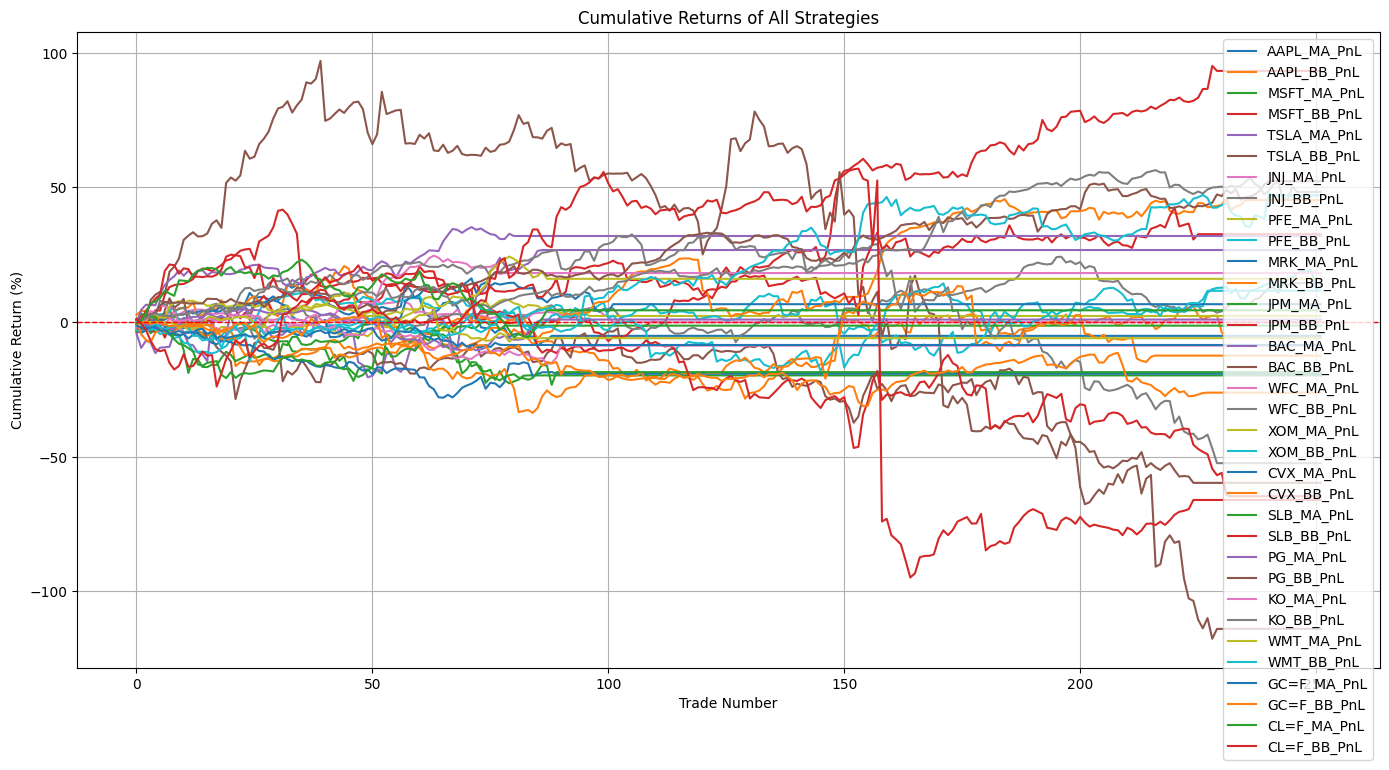

In [11]:
# Plot all cumulative returns on single graph
plt.figure(figsize=(14, 8))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
plt.title("Cumulative Returns of All Strategies")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return (%)")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("cumulative_returns_all_strategies.png")
plt.show()

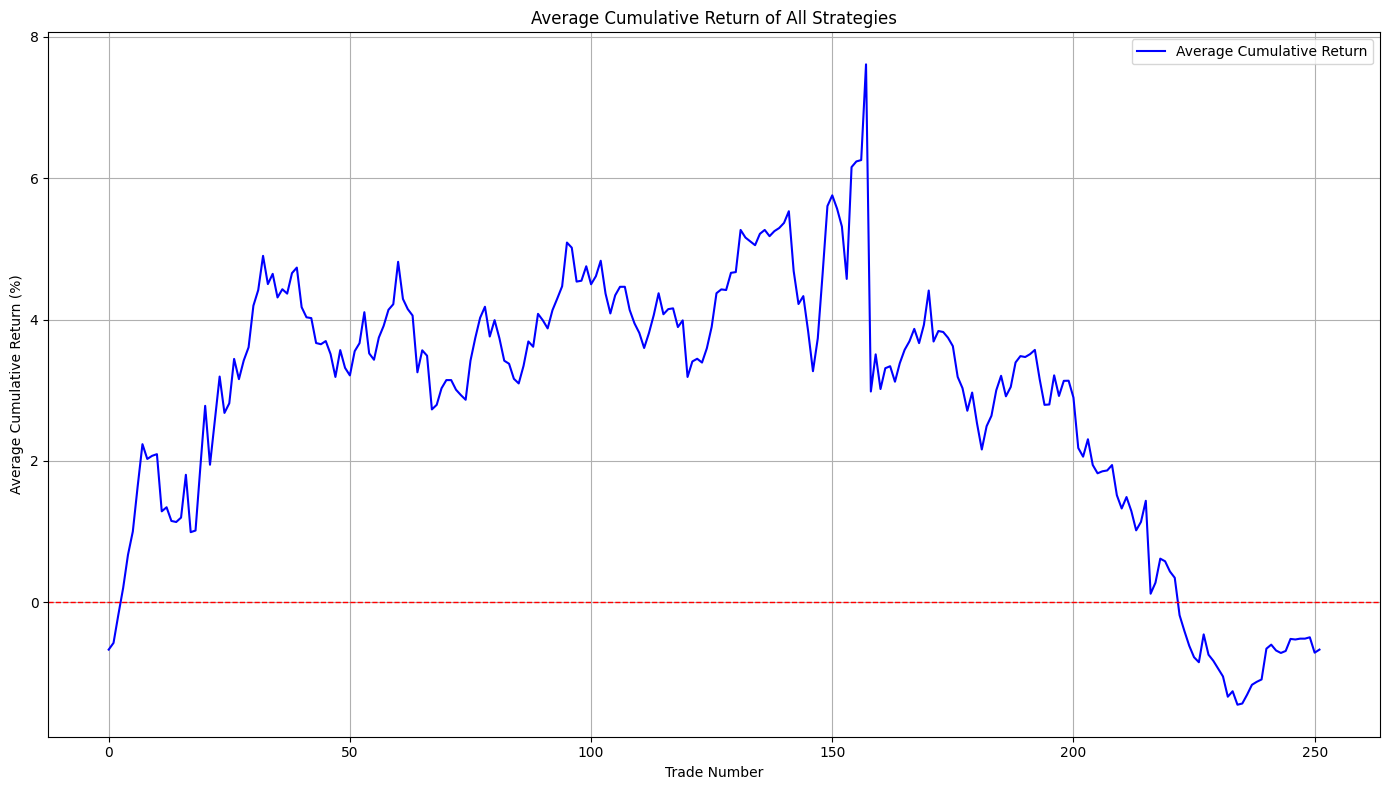

In [12]:
# Plot the average cumulative return of all strategies graph
average_cumulative_return = cumulative_returns.mean(axis=1)
plt.figure(figsize=(14, 8))
plt.plot(average_cumulative_return.index, average_cumulative_return, label='Average Cumulative Return', color='blue')
plt.title("Average Cumulative Return of All Strategies")
plt.xlabel("Trade Number")
plt.ylabel("Average Cumulative Return (%)")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("average_cumulative_return_all_strategies.png")
plt.show()

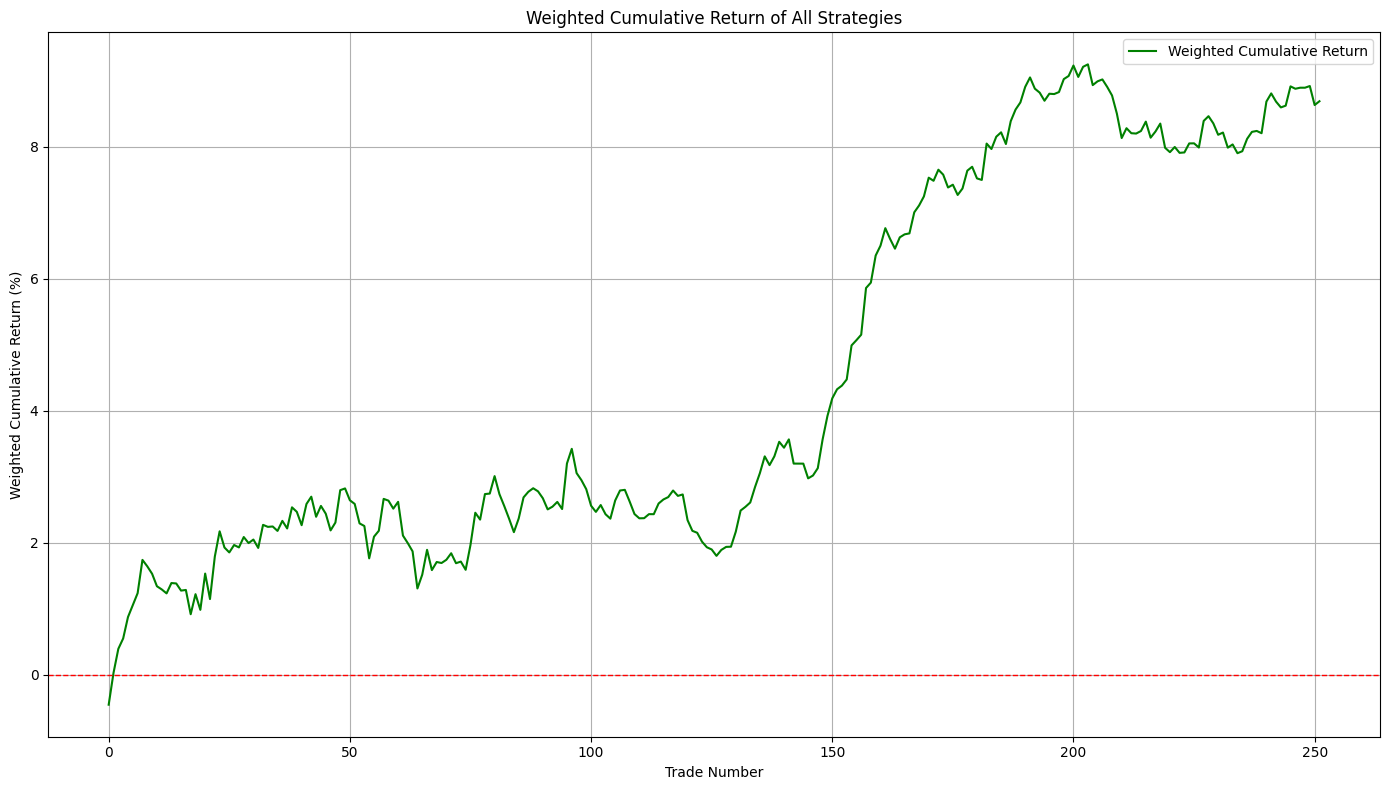

In [15]:
# Plot the weighted cumulative return of all strategies graph using optimal weights
weighted_cumulative_return = (cumulative_returns * optimal_weights).sum(axis=1)
plt.figure(figsize=(14, 8))
plt.plot(weighted_cumulative_return.index, weighted_cumulative_return, label='Weighted Cumulative Return', color='green')
plt.title("Weighted Cumulative Return of All Strategies")
plt.xlabel("Trade Number")
plt.ylabel("Weighted Cumulative Return (%)")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("weighted_cumulative_return_all_strategies.png")
plt.show()